# FRASAL - Rilevazione delle anomalie con tecniche di apprendimento automatico dai dati

Il seguente notebook fornisce la metodologia utilizzata per l'addestramento di un modello di apprendimento automatico al fine di classificare automaticamente le anomalie e/o presunti guasti.

## Analisi dei dati

Il dataset è stato caricato all'interno di un foglio gsheet esportabile in csv.

Preliminarmente il dataset viene caricato all'interno del notebook attraverso una fetch http da gsheet con la funzione 

```
fetch_frasal_data (file_url, data_path)
```




In [ ]:
import os
import tarfile
import urllib.request

DOWNLOAD_FILE = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSL7SdxKVAe864US4WNcKQiwFNHR8qf4SG5fWy0R4wpFNX5ECGgOlrqMZ1yvGtKPG9k2lHI5caxmt_B/pub?gid=273652227&single=true&output=csv"
DATA_DIR  = "dataset_frasal" 
DATA_FILE = "frasal_data.csv"
DATA_PATH = os.path.join(DATA_DIR,DATA_FILE)

def fetch_frasal_data(file_url=DOWNLOAD_FILE,data_path=DATA_PATH):
    os.makedirs(DATA_DIR, exist_ok=True)
    urllib.request.urlretrieve(file_url,data_path)

fetch_frasal_data();

Il file viene analizzato con le librerie Panda che permette l'utilizzo della struttra data DataFrame. Il DataFrame è contenuto nella variabile **data**

In [ ]:
import pandas as pd

def load_frasal_data(data_path=DATA_PATH):
  return pd.read_csv(data_path)

data = load_frasal_data()

Con **head** vengono mostrate le prime 10 righe del DataFrame. 

La struttura del dataset è composta da 9 attributi che definiscono l'istanza da classificare e 2 attributi per la classificazione.

Il primo attributo è la Classe che definisce la categoria del malfunzionamento:

1. **A** → Perdita nel sistema di aria di mandata (entrata aria calda)
2. **F** → Causa filtri UTA intasati, non favoriscono lo scambio termico.
3. **P** → Guasto al sistema di pompaggio, oppure perdia di acqua
4. **V** → Causa Rottura Ventole di estrazione, peggiora la fluidodinamica negli ambienti da condizionare
5. **C** → Rottura Gruppo frigo, Problema compressore/perdita liquido/altra rottura.
6. **N** → Normale

Il secondo attributo è Classe N/P che definisce la se il malfunzionamento esiste (**N**) oppure no (**P**).

In [ ]:
data.head(10)

,misura term. mand.,misura term. Rit.,misura term. mand..1,misura term. Rit..1,Temp. Ambiente,Delta pressione differenziale,Delta Pressione Filtri polveri grandi [Pa],Delta Pressione Filtri polveri sottili [Pa],Misuratori amperometrici,Classe,Classe N/P
0,7.0,12.0,16.0,26.0,26.0,4.0,105,115,3.5,N,N
1,7.0,12.0,16.0,26.0,26.0,4.2,105,115,3.5,N,N
2,7.0,12.0,16.0,26.0,26.0,4.1,105,115,3.6,N,N
3,7.0,12.0,16.0,26.0,26.0,4.3,105,115,3.5,N,N
4,7.0,12.0,16.0,26.0,26.0,4.4,105,115,3.6,N,N
5,7.0,12.0,16.0,26.0,26.0,4.3,105,115,3.5,N,N
6,7.0,12.0,16.0,26.0,26.0,4.4,105,115,3.6,N,N
7,7.0,12.0,16.0,26.0,26.0,4.2,105,115,3.7,N,N
8,7.0,12.0,16.0,26.0,26.0,4.1,105,115,3.7,N,N
9,7.0,12.0,16.0,26.0,26.0,4.5,105,115,3.7,N,N


Con **info** si ottiene una breve descrizione dei dati, in particolare del numero totale di righe (153), tipo di ogni attributo, eventuali valori nulli (non presenti).

Gli attributi sono tutti completi (non esistono valori nulli) inoltre sono tutti numerici. La natura dei valori è disomogenea poichè alcuni attributi rappresentano temperature altri la pressione ed uno la corrente (*Misuratori amperomerici*).

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   misura term. mand.                           153 non-null    float64
 1   misura term. Rit.                            153 non-null    float64
 2   misura term. mand..1                         153 non-null    float64
 3   misura term. Rit..1                          153 non-null    float64
 4   Temp. Ambiente                               153 non-null    float64
 5   Delta pressione differenziale                153 non-null    float64
 6   Delta Pressione Filtri polveri grandi [Pa]   153 non-null    int64  
 7   Delta Pressione Filtri polveri sottili [Pa]  153 non-null    int64  
 8   Misuratori amperometrici                     153 non-null    float64
 9   Classe                                       153 non-null    object 
 10  Cl

L'attributo Classe rappresenta il tipo di guasto da analizzare/prevedere nel modello. La distribuzione è sbilanciata sui guasti in particolare sulla classe F (*Filtri UTA intasati*).

In [ ]:
data["Classe"].value_counts()

F    51
P    28
V    22
C    20
N    19
A    13
Name: Classe, dtype: int64

L'attributo Classe N/P rappresenta se esiste il guasto o meno. La distribuzione è sbilanciata sui guasti (*P*
).

In [ ]:
data["Classe N/P"].value_counts()

P    134
N     19
Name: Classe N/P, dtype: int64

Per l'analisi della distribuzione dei valori degli attributi che definiscono l'istanza vengono utilizzati nel seguito gli istogrammi di distribuzione su 10 bin.

Le figure mostrano che ci sono dei valori di disribuzione dicotomiche 'standard' per le misure di pressione rappresentative la normalità e l'anomalia.

**misura term. Rit..1** e **Temperatura ambiente** hanno una distribuzione molto simile, suggerendo una stretta correlazione.

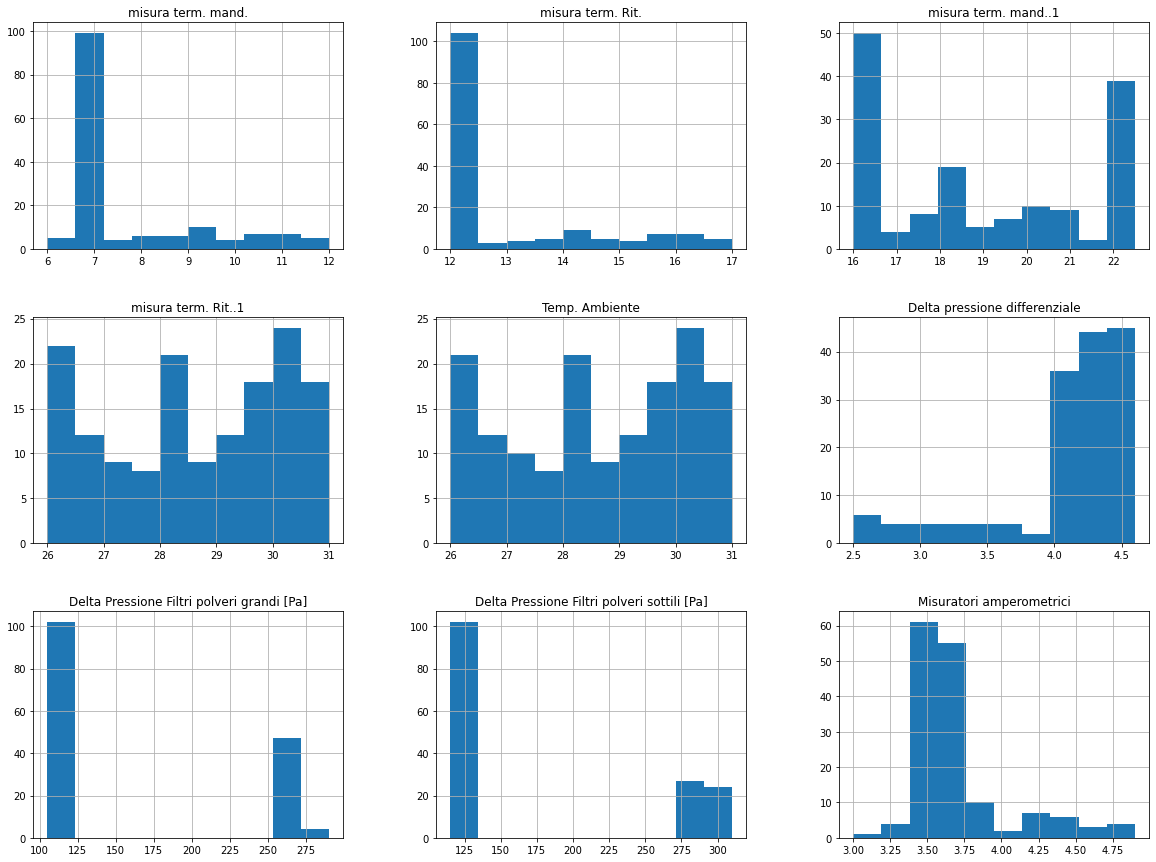

In [ ]:
import matplotlib.pyplot as plt
data.hist(bins=10, figsize=(20,15))
plt.show()

L'analisi prosegue con la correlazione tra le variabili, attraverso l'analisi della matrice di correlazione.

Ci sono alcune feature strettamente correlate.

La correlazione può essere utile nel momento in cui alcuni valori non sono presenti in fase di test, creando artificialmente i valori mancanti.

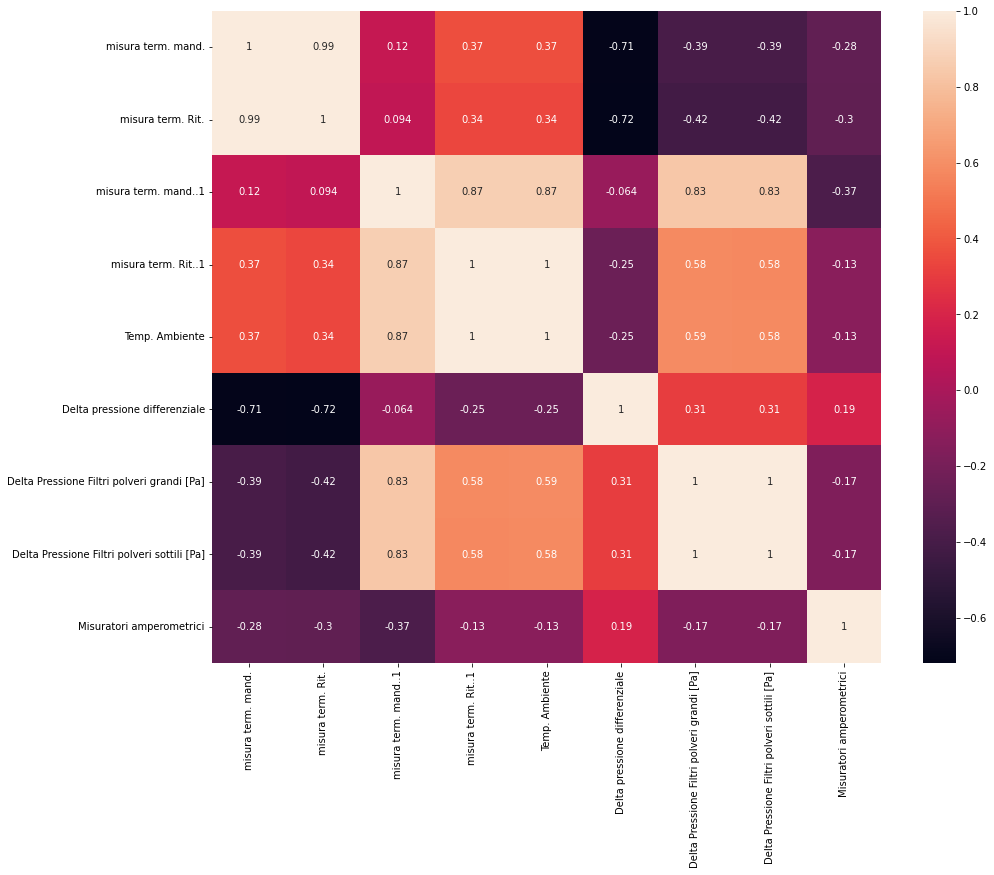

In [ ]:
import seaborn as sns

corr_matrix = data.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True)

Lo split dei dati è fatto mediante una funzione che prende in modo casuale il dataset di partenza e lo divide in 2 secondo la proporzione 80/20 (training/test)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data,test_size=0.2,random_state=42)

# Topologia dei Decisori

La topologia dell'addestramento prevede un decisore (D1) che fornisce una predizione se l'istanza analizzata è un'anomalia o meno.

A seguito dell'alert viene analizzato il contenuto dell'istanza da un altro decisore (D2) che ha lo scopo di classificare l'istanza nelle varie categorie di anomalia previste dal dataset.

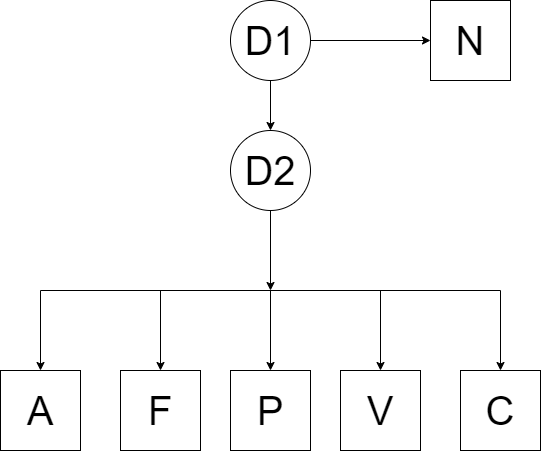


Prima di procedere all'addestramento dei modelli, è necessario creare opportunamento dati e label di addestramento del primo decisore, per la classificazione binaria.

In [ ]:
training_data_01 = train_set.drop("Classe",axis=1)
training_data_01 = training_data_01.drop("Classe N/P",axis=1)
training_data_01 = training_data_01.values
training_label_01 = train_set["Classe N/P"].copy()

test_data_01  = test_set.drop("Classe",axis=1)
test_data_01  = test_data_01.drop("Classe N/P",axis=1)
test_data_01  = test_data_01.values
test_label_01 = test_set["Classe N/P"].copy()


Il primo modello è un albero di decisione.

Nelle figure è mostrato l'output (testuale e grafico).

|--- feature_4 <= 26.25
|   |--- feature_0 <= 6.50
|   |   |--- class: P
|   |--- feature_0 >  6.50
|   |   |--- class: N
|--- feature_4 >  26.25
|   |--- class: P



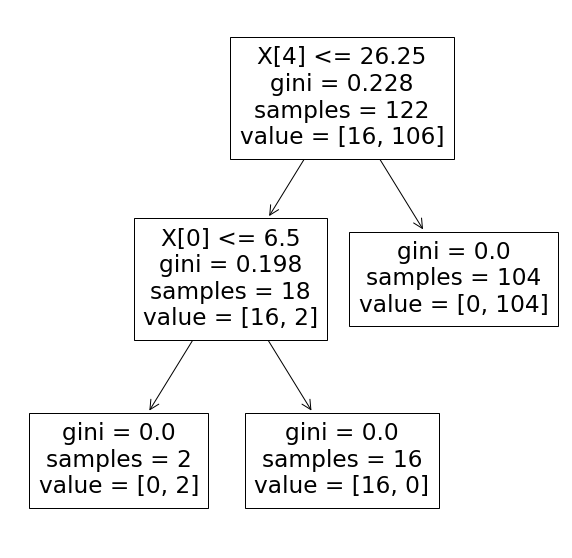

In [ ]:
from sklearn import tree

tree_clf_01 = tree.DecisionTreeClassifier()
tree_clf_01 = tree_clf_01.fit(training_data_01, training_label_01)

text_representation = tree.export_text(tree_clf_01)
print(text_representation)
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(tree_clf_01)



Il secondo modello è una rete neurale multistrato con uno strato di 5 neuroni nascosti.


In [ ]:
from sklearn.neural_network import MLPClassifier
NN_clf_01 = MLPClassifier(solver='sgd', 
                          hidden_layer_sizes=(5, 2), 
                          random_state=1,
                          learning_rate_init=0.001,
                          max_iter=99999)
NN_clf_01 = NN_clf_01.fit(training_data_01, training_label_01)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

svm_clf_01 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42,max_iter=990000))
    ])

svm_clf_01 = svm_clf_01.fit(training_data_01, training_label_01)


In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf_01 = VotingClassifier(
    estimators=[('lr', tree_clf_01), ('rf', NN_clf_01), ('svc', svm_clf_01)],
    voting='hard')

voting_clf_01 = voting_clf_01.fit(training_data_01, training_label_01)

# Decisiore multiclasse

Preparazione del dataset

In [ ]:
data_01 = train_set.drop(train_set[train_set.Classe=='N'].index)
training_data = data_01.drop("Classe",axis=1)
training_data = training_data.drop("Classe N/P",axis=1)
training_data = training_data.values
training_label = data_01["Classe"].copy()

tdata_01 = test_set.drop(test_set[test_set.Classe=='N'].index)
test_data = tdata_01.drop("Classe",axis=1)
test_data = test_data.drop("Classe N/P",axis=1)
test_data = test_data.values
test_label = tdata_01["Classe"].copy()

Addestramento dell'albero di decisione

|--- feature_6 <= 180.00
|   |--- feature_5 <= 3.90
|   |   |--- class: P
|   |--- feature_5 >  3.90
|   |   |--- feature_1 <= 12.25
|   |   |   |--- feature_8 <= 3.75
|   |   |   |   |--- class: A
|   |   |   |--- feature_8 >  3.75
|   |   |   |   |--- class: V
|   |   |--- feature_1 >  12.25
|   |   |   |--- class: C
|--- feature_6 >  180.00
|   |--- class: F



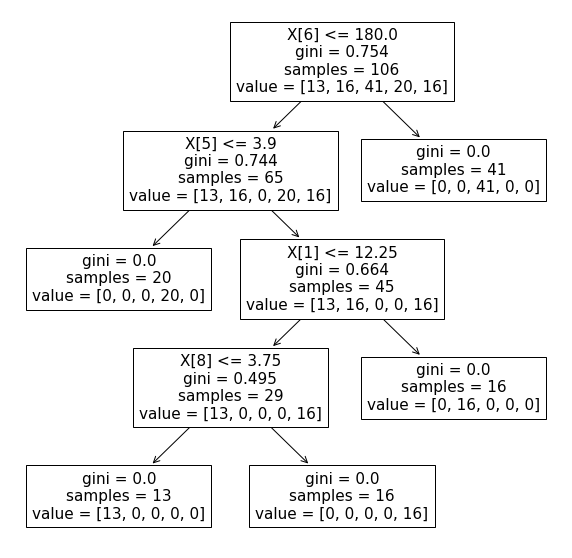

In [ ]:
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(training_data, training_label)

text_representation = tree.export_text(tree_clf)
print(text_representation)
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(tree_clf)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'solver': ['lbfgs'],
              'max_iter': [1000,1100,1200,1300,1400 ],
              'alpha': 10.0 ** -np.arange(1, 5),
              'hidden_layer_sizes':np.arange(5, 10),
              'random_state':[0,1]}
NN_clf_grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

NN_clf_grid.fit(training_data, training_label)
NN_clf = NN_clf_grid.best_estimator_
NN_clf = NN_clf.fit(training_data, training_label)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42,max_iter=90000))
    ])

svm_clf = svm_clf.fit(training_data, training_label)

# Test del modello addestrato

[1. 1. 1.]
[0.9 1.  1. ]
[[ 4  0  0  0]
 [ 0 10  0  0]
 [ 0  0  8  0]
 [ 0  0  0  6]]


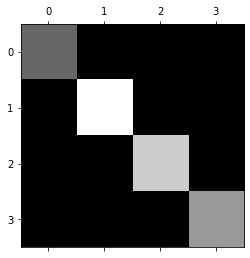

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

print(cross_val_score(tree_clf_01,test_data_01,test_label_01,cv=3, scoring="accuracy"))
print(cross_val_score(tree_clf,test_data,test_label,cv=3, scoring="accuracy"))

y_train_pred_tree=cross_val_predict(tree_clf,test_data,test_label,cv=3)
conf_mx_tree = confusion_matrix(test_label,y_train_pred_tree)
print(conf_mx_tree)

plt.matshow(conf_mx_tree, cmap=plt.cm.gray)
plt.show()


[0.90909091 0.9        0.9       ]
[0.8 1.  1. ]
[[ 2  0  1  1]
 [ 0 10  0  0]
 [ 0  0  8  0]
 [ 0  0  0  6]]


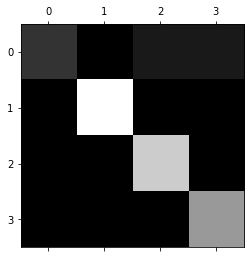

In [ ]:
print(cross_val_score(NN_clf_01,test_data_01,test_label_01,cv=3, scoring="accuracy"))
print(cross_val_score(NN_clf,test_data,test_label,cv=3, scoring="accuracy"))

y_train_pred_NN=cross_val_predict(NN_clf,test_data,test_label,cv=3)
conf_mx_NN = confusion_matrix(test_label,y_train_pred_NN)
print(conf_mx_NN)

plt.matshow(conf_mx_NN, cmap=plt.cm.gray)
plt.show()

[1.  0.9 0.9]
[0.9 1.  1. ]
[[ 3  0  1  0]
 [ 0 10  0  0]
 [ 0  0  8  0]
 [ 0  0  0  6]]


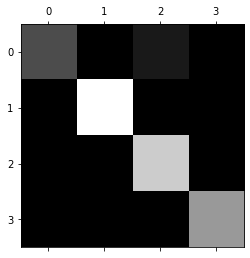

In [ ]:
print(cross_val_score(svm_clf_01,test_data_01,test_label_01,cv=3, scoring="accuracy"))
print(cross_val_score(svm_clf,test_data,test_label,cv=3, scoring="accuracy"))

y_train_pred_svm=cross_val_predict(svm_clf,test_data,test_label,cv=3)
conf_mx_svm = confusion_matrix(test_label,y_train_pred_svm)
print(conf_mx_svm)

plt.matshow(conf_mx_svm, cmap=plt.cm.gray)
plt.show()

La rete, nel problema multiclass, non fornisce valorizzazioni coerenti. Pertanto nel voting si è deciso di non tenerla in considerazione.

[1.  1.  0.9]
[0.9 1.  1. ]
[[ 3  0  0  1]
 [ 0 10  0  0]
 [ 0  0  8  0]
 [ 0  0  0  6]]


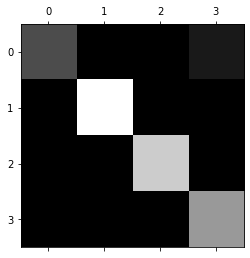

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('lr', tree_clf),('nn',NN_clf),('svc', svm_clf)],
    voting='hard')

voting_clf = voting_clf.fit(training_data, training_label)

print(cross_val_score(voting_clf_01,test_data_01,test_label_01,cv=3, scoring="accuracy"))
print(cross_val_score(voting_clf,test_data,test_label,cv=3, scoring="accuracy"))

y_train_pred_vt=cross_val_predict(voting_clf,test_data,test_label,cv=3)
conf_mx_vt = confusion_matrix(test_label,y_train_pred_vt)
print(conf_mx_vt)

plt.matshow(conf_mx_vt, cmap=plt.cm.gray)
plt.show()

# Salvare e caricare (ed utilizzare) il modello addestrato
Per salvare il modello si è fatto utilizzo della libreria joblib, che salva in modo persistente i decisori addestrati con i dati di training

In [ ]:
from joblib import dump, load
dump(voting_clf_01,  'frasal_model_D1.joblib')
dump(voting_clf, 'frasal_model_D2.joblib')

['frasal_model_D2.joblib']

Per utilizzare il modello è necessario ricaricare i decisori addestrati e procedere in cascata in coerenza con la topologia descritta precedentemente.

In [ ]:
predict_clf_01 = load('frasal_model_D1.joblib')
predict_clf    = load('frasal_model_D2.joblib')

st = [7.5,	12.5,	16.5,	26.5,	26.5,	4.2,	105,	115,	3.5]

val = predict_clf_01.predict([st])[0]

if (val=='P'):
  print(predict_clf.predict([st]))
else:
  print(val);

['C']


Per utilizzare il modello all'interno di un servizio REST in FLASK, si suggerisce di installare la versione di scikitlearn 1.0.2

`pip install scikit-learn==1.0.2`

All'interno dell'applicazione FLASK inserire il seguente codice di esempio:



```
import flask
from flask import request, jsonify
from joblib import dump, load

app = flask.Flask(__name__)

@app.route('/', methods=['GET'])
def home():
    x1 = request.args.get('x1')
    x2 = request.args.get('x2')
    x3 = request.args.get('x3')
    x4 = request.args.get('x4')
    x5 = request.args.get('x5')
    x6 = request.args.get('x6')
    x7 = request.args.get('x7')
    x8 = request.args.get('x8')
    x9 = request.args.get('x9')

    predict_clf_D1 = load('frasal_model_D1.joblib')
    predict_clf_D2 = load('frasal_model_D2.joblib')

    st = [x1, x2, x3, x4, x5, x6, x7, x8, x9]

    val = predict_clf_D1.predict([st]).flatten()[0]

    if (val == 'P'):
        val = predict_clf_D2.predict([st]).flatten()[0]

    return jsonify(val)

app.run()
```


